In [1]:
! pip install -q tensorflow_text

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.0/6.0 MB 79.7 MB/s eta 0:00:00


In [2]:
! pip install -q tf-models-official

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.6/2.6 MB 79.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.6/43.6 kB 5.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 118.9/118.9 kB 13.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 175.1/175.1 kB 19.7 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 240.6/240.6 kB 22.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 591.0/591.0 kB 46.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 61.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 17.1/17.1 MB 91.1 MB/s eta 0:00:00


In [3]:
import tensorflow as tf
import tensorflow_hub as hub
import tensorflow_text as text          # needed for loading bert from hub
from official.nlp import optimization   # to create AdamW optimizer

tf.get_logger().setLevel('ERROR')
print(tf.__version__)
tf.config.list_physical_devices('GPU')

/usr/local/lib/python3.10/dist-packages/tensorflow_addons/utils/tfa_eol_msg.py:23: UserWarning: 

TensorFlow Addons (TFA) has ended development and introduction of new features.
TFA has entered a minimal maintenance and release mode until a planned end of life in May 2024.
Please modify downstream libraries to take dependencies from other repositories in our TensorFlow community (e.g. Keras, Keras-CV, and Keras-NLP). 

For more information see: https://github.com/tensorflow/addons/issues/2807 

  warnings.warn(


2.12.0


[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [4]:
from utils.preprocessing import preprocess

AUTOTUNE = tf.data.AUTOTUNE
BUFFER_SIZE = 256
BATCH_SIZE = 32
raw_ds = preprocess('bert')

Total number of news: 30339
Maximum number of news for each group in training set: 64
Minimum number of news for each group in training set: 3
Maximum number of news for each group in test set: 26
Minimum number of news for each group in test set: 3
Maximum number of times a news appears in training set: 22
Minimum number of times a news appears in training set: 0
Maximum number of times a news appears in test set: 11
Minimum number of times a news appears in test set: 0


In [5]:
def gen(name='train'):
    for newsID, label in raw_ds[name]:
        titles = ' '.join([raw_ds['news'][i][0] for i in newsID])
        contents = ' '.join([raw_ds['news'][i][1] for i in newsID])
        yield (titles, contents), label

def gen_test():
    for newsID in raw_ds['test']:
        titles = ' '.join([raw_ds['news'][i][0] for i in newsID])
        contents = ' '.join([raw_ds['news'][i][1] for i in newsID])
        yield titles, contents

train_ds = tf.data.Dataset.from_generator(
    gen, output_signature=(
        tf.TensorSpec(shape=(2,), dtype=tf.string),
        tf.TensorSpec(shape=(), dtype=tf.int32)
    )
).shuffle(BUFFER_SIZE).batch(BATCH_SIZE).prefetch(AUTOTUNE)
valid_ds = tf.data.Dataset.from_generator(
    lambda: gen('valid'), output_signature=(
        tf.TensorSpec(shape=(2,), dtype=tf.string),
        tf.TensorSpec(shape=(), dtype=tf.int32)
    )
).shuffle(BUFFER_SIZE).batch(BATCH_SIZE).prefetch(AUTOTUNE)
test_ds = tf.data.Dataset.from_generator(
    gen_test, output_signature=(
        tf.TensorSpec(shape=(2,), dtype=tf.string)
    )
).batch(BATCH_SIZE).prefetch(AUTOTUNE)
train_ds, valid_ds, test_ds

(<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 2), dtype=tf.string, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>,
 <_PrefetchDataset element_spec=(TensorSpec(shape=(None, 2), dtype=tf.string, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>,
 <_PrefetchDataset element_spec=TensorSpec(shape=(None, 2), dtype=tf.string, name=None)>)

In [6]:
num_train = train_ds.reduce(0, lambda x, _: x + 1).numpy()
num_valid = valid_ds.reduce(0, lambda x, _: x + 1).numpy()
num_train, num_valid

(224, 25)

In [7]:
print(list(train_ds.take(1))[0][0].numpy().shape)
list(train_ds.take(1))[0][1]

(32, 2)


<tf.Tensor: shape=(32,), dtype=int32, numpy=
array([1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 0,
       1, 0, 0, 1, 1, 1, 0, 1, 1, 0], dtype=int32)>

In [10]:
from model import bert

tfhub_handle_encoder, tfhub_handle_preprocess = bert.load_handle()

BERT model selected           : https://tfhub.dev/tensorflow/bert_zh_L-12_H-768_A-12/4
Preprocess model auto-selected: https://tfhub.dev/tensorflow/bert_zh_preprocess/3


In [ ]:
bert_preprocess_model = hub.KerasLayer(tfhub_handle_preprocess)
bert_encoder = hub.KerasLayer(tfhub_handle_encoder)

In [ ]:
text_test = ['航天军工改制', '复旦大小']
text_preprocessed = bert_preprocess_model(text_test)
print('preprocess:')
print(f'\tKeys       : {list(text_preprocessed.keys())}')
print(f'\tShape      : {text_preprocessed["input_word_ids"].shape}')
print(f'\tWord Ids   : {text_preprocessed["input_word_ids"][0, :12]}')
print(f'\tInput Mask : {text_preprocessed["input_mask"][0, :12]}')
print(f'\tType Ids   : {text_preprocessed["input_type_ids"][0, :12]}')

bert_results = bert_encoder(text_preprocessed)
print('encoder:')
print(f'\tLoaded BERT: {tfhub_handle_encoder}')
print(f'\tPooled Outputs Shape:{bert_results["pooled_output"].shape}')
print(f'\tPooled Outputs Values:{bert_results["pooled_output"][0, :12]}')
print(f'\tSequence Outputs Shape:{bert_results["sequence_output"].shape}')
print(f'\tSequence Outputs Values:{bert_results["sequence_output"][0, :12]}')

preprocess:
	Keys       : ['input_word_ids', 'input_type_ids', 'input_mask']
	Shape      : (2, 128)
	Word Ids   : [ 101 5661 1921 1092 2339 3121 1169  102    0    0    0    0]
	Input Mask : [1 1 1 1 1 1 1 1 0 0 0 0]
	Type Ids   : [0 0 0 0 0 0 0 0 0 0 0 0]
encoder:
	Loaded BERT: https://tfhub.dev/tensorflow/bert_zh_L-12_H-768_A-12/4
	Pooled Outputs Shape:(2, 768)
	Pooled Outputs Values:[ 0.9991402   0.9967849   0.99997956  0.8220248   0.86295706 -0.18127915
  0.29894182 -0.7535787   0.9343412  -0.9979432   0.99999493  0.9999995 ]
	Sequence Outputs Shape:(2, 128, 768)
	Sequence Outputs Values:[[-0.20063053  0.42701313  0.11472083 ...  0.14706677 -0.09248966
   0.01925603]
 [ 0.40039676  0.54849184  0.30547076 ... -0.81683505 -0.5737129
  -0.2251461 ]
 [ 1.6686405   0.33606017 -0.96543264 ... -0.67803603  0.22344837
  -0.08616167]
 ...
 [-0.5480576   0.5407157   0.09424008 ...  0.19394217 -0.7270278
  -0.31262705]
 [-0.6101384   0.44203866 -0.16109388 ...  0.21111527 -0.7106892
  -0.23948

In [8]:
loss = tf.keras.losses.BinaryCrossentropy(from_logits=False)
metrics = tf.metrics.BinaryAccuracy()
epochs = 20
num_train_steps = num_train * epochs
num_warmup_steps = int(0.1 * num_train_steps)
init_lr = 1e-4
optimizer = optimization.create_optimizer(init_lr=init_lr,
                                          num_train_steps=num_train_steps,
                                          num_warmup_steps=num_warmup_steps,
                                          optimizer_type='adamw')
callbacks = tf.keras.callbacks.TensorBoard(log_dir='logs')
title_units = 32
content_units = 128

In [11]:
# bert_model = bert.BertModel(tfhub_handle_preprocess, tfhub_handle_encoder, title_units, content_units)
bert_model = bert.build_classifier_model(tfhub_handle_preprocess, tfhub_handle_encoder, title_units, content_units, fine_tune=False)

In [12]:
from utils.visualization import plot_structure, plot_history

plot_structure(bert_model, 'bert_classifier.png')

In [13]:
bert_model.compile(optimizer=optimizer, loss=loss, metrics=metrics)
print(f'Training model with {tfhub_handle_encoder}')
history = bert_model.fit(train_ds, validation_data=valid_ds, epochs=epochs, callbacks=[callbacks])

Training model with https://tfhub.dev/tensorflow/bert_zh_L-12_H-768_A-12/4
Epoch 1/20
224/224 [==============================] - 498s 2s/step - loss: 0.6413 - binary_accuracy: 0.6253 - val_loss: 0.6215 - val_binary_accuracy: 0.6508
Epoch 2/20
224/224 [==============================] - 472s 2s/step - loss: 0.6232 - binary_accuracy: 0.6401 - val_loss: 0.7456 - val_binary_accuracy: 0.5553
Epoch 3/20
224/224 [==============================] - 487s 2s/step - loss: 0.6384 - binary_accuracy: 0.6324 - val_loss: 0.6369 - val_binary_accuracy: 0.6583
Epoch 4/20
224/224 [==============================] - 470s 2s/step - loss: 0.6146 - binary_accuracy: 0.6558 - val_loss: 0.6978 - val_binary_accuracy: 0.6508
Epoch 5/20
224/224 [==============================] - 469s 2s/step - loss: 0.6042 - binary_accuracy: 0.6655 - val_loss: 0.6341 - val_binary_accuracy: 0.6445
Epoch 6/20
224/224 [==============================] - 467s 2s/step - loss: 0.5407 - binary_accuracy: 0.7251 - val_loss: 0.6706 - val_binary_

dict_keys(['loss', 'binary_accuracy', 'val_loss', 'val_binary_accuracy'])


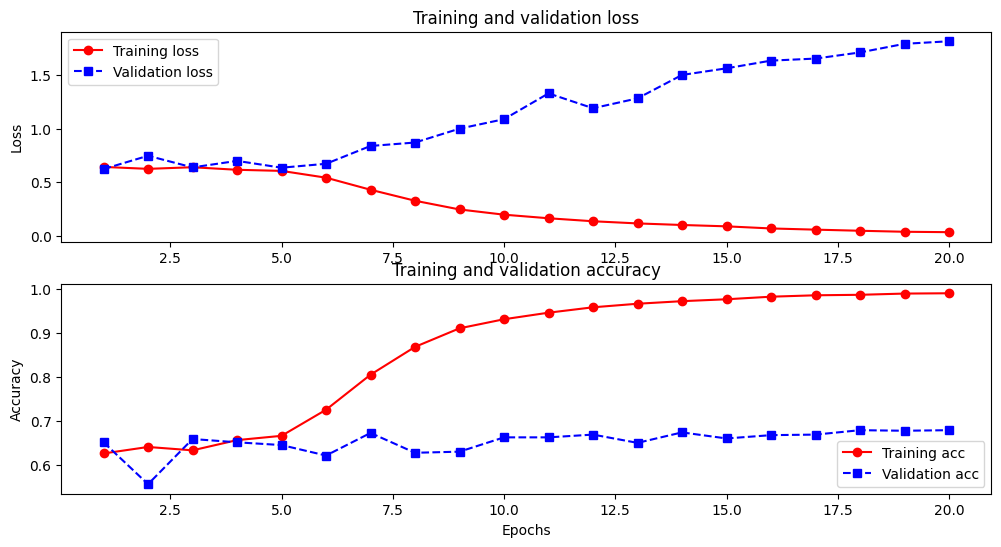

In [14]:
plot_history(history.history)

In [15]:
from utils.prediction import predict

predict(bert_model, test_ds, 'bert_prediction.txt')

94/94 [==============================] - 85s 893ms/step


array([[0.99783343],
       [0.00129715],
       [0.99556786],
       ...,
       [0.9906596 ],
       [0.00128738],
       [0.99870014]], dtype=float32)